In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
path = "/content/drive/MyDrive/corona_project/"
df_test=pd.read_csv(path+"df_test.csv", index_col=0, encoding = "ISO-8859-1")
df_train=pd.read_csv(path+"df_train.csv", index_col=0, encoding = "ISO-8859-1")
X_train = df_train.drop('SARS-Cov-2 exam result', axis=1)
y_train = df_train['SARS-Cov-2 exam result']
X_test = df_test.drop('SARS-Cov-2 exam result', axis=1)
y_test = df_test['SARS-Cov-2 exam result']

## Evaluation Procedure

In [6]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [7]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

## Modellisation

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [9]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [10]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [11]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71  

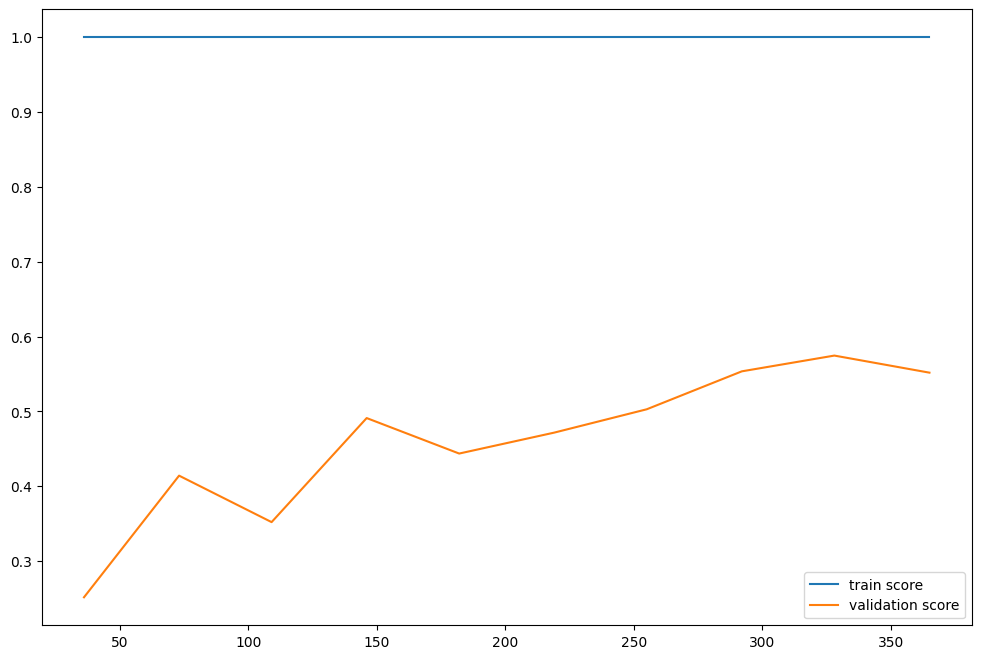

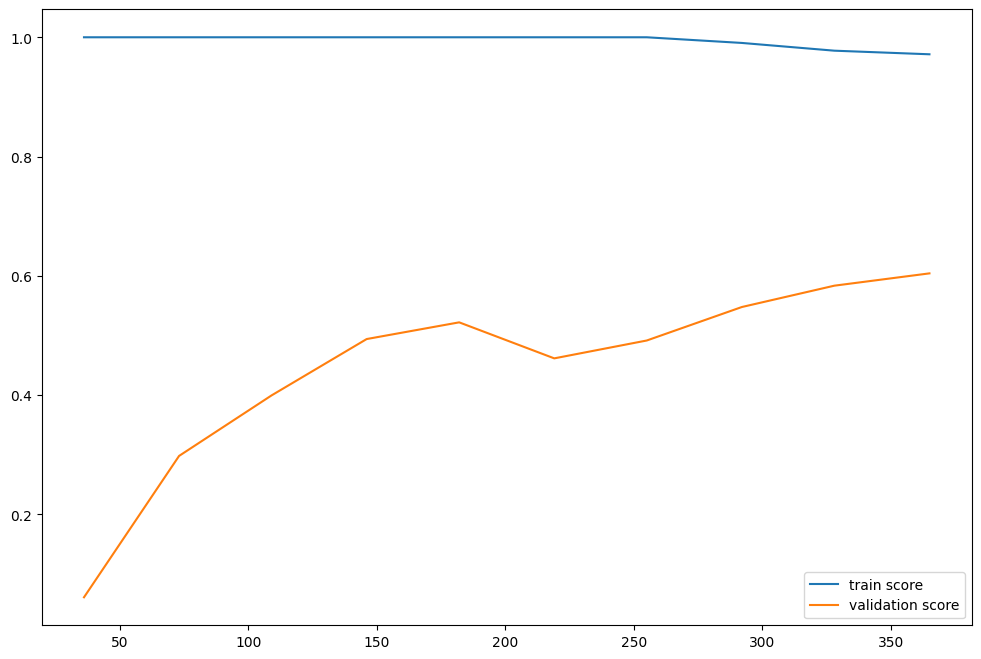

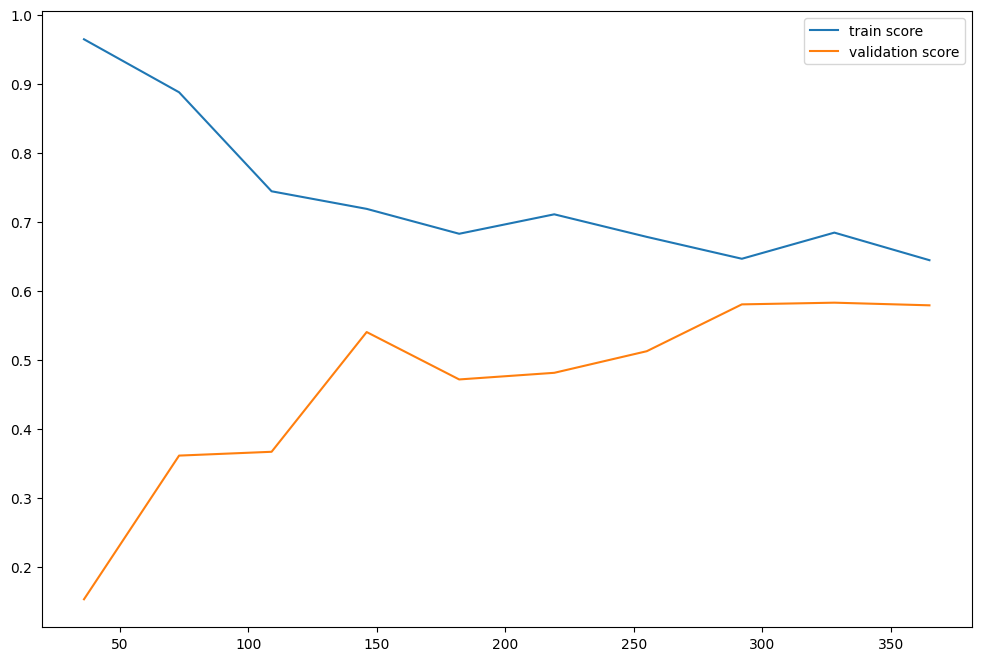

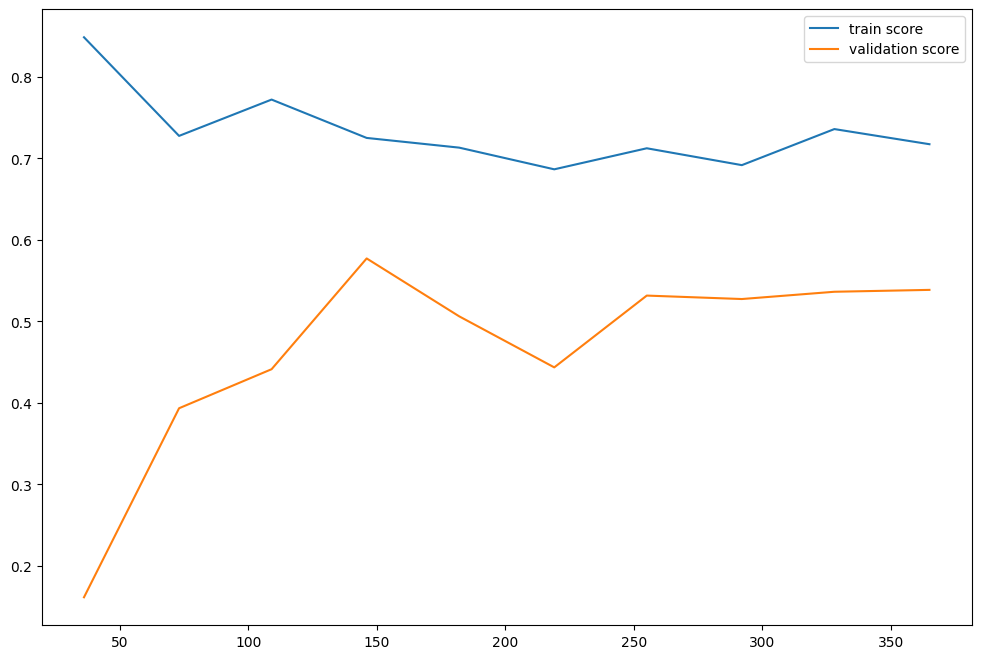

In [12]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## OPTIMISATION

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [14]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [15]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

In [16]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.0005, 'svc__C': 3000, 'pipeline__selectkbest__k': 54, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

    accuracy                           0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



[[88  7]
 [ 7  9]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

    accuracy                           0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



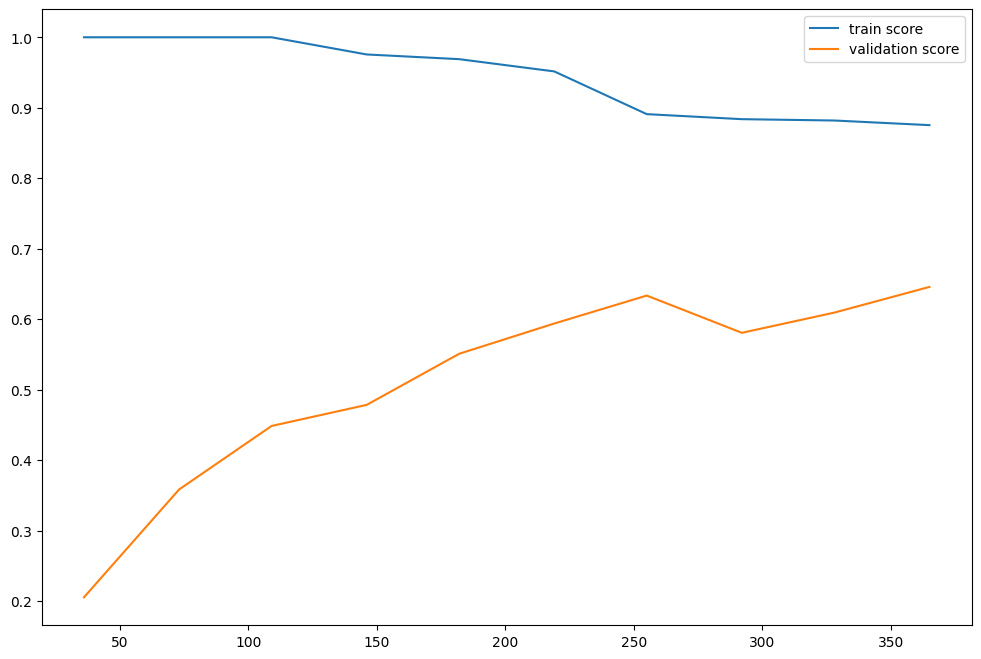

In [17]:
evaluation(grid.best_estimator_)

## Precision Recall Curve

In [18]:
from sklearn.metrics import precision_recall_curve

In [19]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

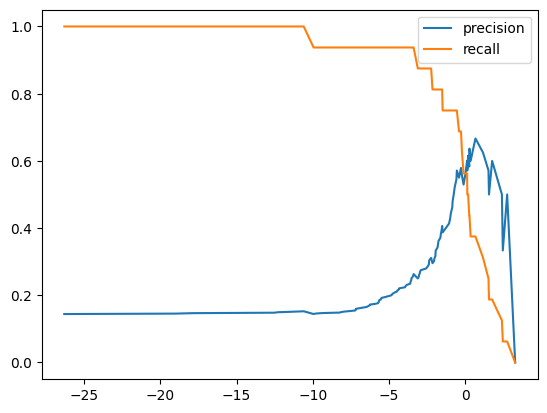

In [20]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [21]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [22]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [23]:
from sklearn.metrics import recall_score

In [24]:
f1_score(y_test, y_pred)

0.5454545454545454

In [25]:
recall_score(y_test, y_pred)

0.75